In [148]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import length, split, size, udf
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [134]:
# Initialize spark and load dataset
spark = SparkSession.builder.appName("HypothesisTesting").getOrCreate()

hdfs_path = "hdfs://localhost:54310/user/ubuntu/books_dataset/"

# Read dataset from HDFS
df = spark.read.csv(hdfs_path, header=True, inferSchema=True)

# Keep only relevant columns and drop missing values
df = df.select("star_rating", "review_body").dropna()

# Quick sample to check the data
df.sample(withReplacement=False, fraction=0.1).limit(5).show()


+-----------+--------------------+
|star_rating|         review_body|
+-----------+--------------------+
|        3.0|Especially when c...|
|        2.0|I bought this boo...|
|        5.0|This is a fantast...|
|        5.0|I really enjoyed ...|
|        5.0|One hardly expect...|
+-----------+--------------------+



In [135]:
# Feature engineering: word count & lexical diversity

df = df.withColumn("word_count", size(split(col("review_body"), " ")))

# Lexical diversity (unique/total words)
def lexical_diversity(text):
    words = text.split()
    if len(words) == 0:
        return 0.0
    return len(set(words)) / len(words)

lex_div_udf = udf(lexical_diversity, DoubleType())

# Add lexical_diversity column
df = df.withColumn("lexical_diversity", lex_div_udf(col("review_body")))

df.show(5)

+-----------+--------------------+----------+------------------+
|star_rating|         review_body|word_count| lexical_diversity|
+-----------+--------------------+----------+------------------+
|        4.0|Unlike many books...|       107|0.7850467289719626|
|        5.0|This book is the ...|        81|0.8441558441558441|
|        5.0|When I started th...|       129|0.5317460317460317|
|        5.0|This book has som...|        56|0.8113207547169812|
|        4.0|This book is a sm...|       108|0.7129629629629629|
+-----------+--------------------+----------+------------------+
only showing top 5 rows



In [147]:
# Divide word count and lexical diversity into groups
grouped_df = df.groupBy("star_rating").agg(
    F.avg("word_count").alias("avg_word_count"),
    F.avg("lexical_diversity").alias("avg_lexical_diversity")
)

grouped_df.show()

+-----------+------------------+---------------------+
|star_rating|    avg_word_count|avg_lexical_diversity|
+-----------+------------------+---------------------+
|        1.0| 159.4943438914027|    0.757366908202626|
|        4.0|193.03222341568207|   0.7255875323141988|
|        3.0|200.86643026004728|    0.719642057291603|
|        2.0|174.48813559322033|   0.7372424089447392|
|        5.0|146.36644895152975|   0.7571991505899387|
+-----------+------------------+---------------------+



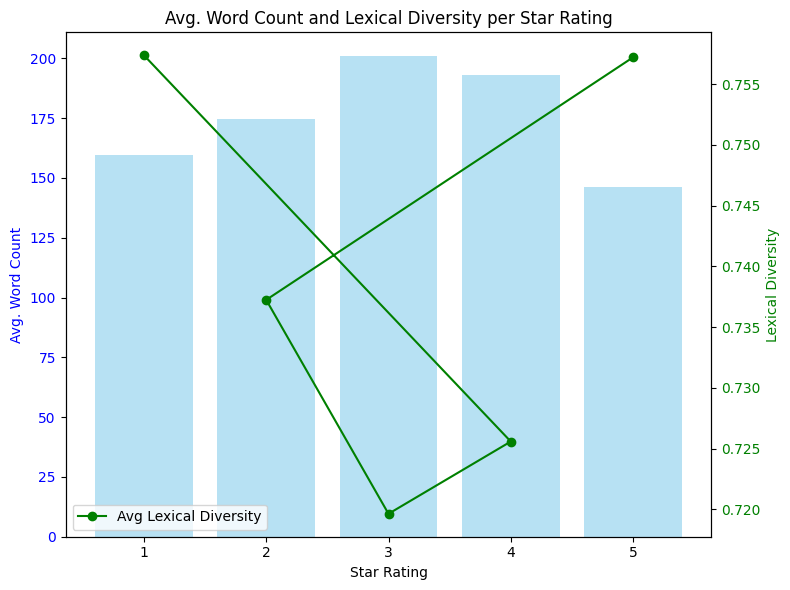

In [149]:
# Compare averages per star rating

# Collect the data into pandas
df_grouped_pd = grouped_df.toPandas()

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plotting word count on the primary y-axis
ax1.bar(df_grouped_pd['star_rating'], df_grouped_pd['avg_word_count'], alpha=0.6, label='Avg Word Count', color='skyblue')
ax1.set_xlabel('Star Rating')
ax1.set_ylabel('Avg. Word Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary y-axis for lexical diversity
ax2 = ax1.twinx()
ax2.plot(df_grouped_pd['star_rating'], df_grouped_pd['avg_lexical_diversity'], label='Avg Lexical Diversity', color='green', marker='o')
ax2.set_ylabel('Lexical Diversity', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Avg. Word Count and Lexical Diversity per Star Rating')
fig.tight_layout()
plt.legend()
plt.show()

In [151]:
# More detailed statistics: mean, median, IQR, 95th percentile
df_wc = df.withColumn("word_count", F.size(F.split(F.col("review_body"), "\s+")))

stats = df_wc.groupBy("star_rating").agg(
    F.mean("word_count").alias("avg_wc"),
    F.expr("percentile(word_count, 0.5)").alias("median_wc"),
    F.expr("percentile(word_count, array(0.25,0.75))").alias("iqr"),
    F.expr("percentile(word_count, 0.95)").alias("p95")
)

stats.show()

+-----------+------------------+---------+--------------+------------------+
|star_rating|            avg_wc|median_wc|           iqr|               p95|
+-----------+------------------+---------+--------------+------------------+
|        1.0|154.15384615384616|    110.0|[63.0, 189.25]|401.39999999999964|
|        4.0|186.81203007518798|    130.0| [74.0, 234.0]| 557.8499999999995|
|        3.0| 193.0177304964539|    144.5|[87.0, 229.75]|            561.25|
|        2.0|169.15254237288136|    126.0|[80.25, 198.5]| 445.0499999999995|
|        5.0| 141.5452045376418|    101.0| [60.0, 170.0]|389.14999999999964|
+-----------+------------------+---------+--------------+------------------+



In [120]:
# Prepare subsets for hypothesis testing

# Filter ratings
one_star_df = df.filter(df["star_rating"] == 1)
three_star_df = df.filter(df["star_rating"] == 3)
five_star_df = df.filter(df["star_rating"] == 5)

# Calculate average word count and lexcial diversity for ratings
one_star_word_count = one_star_df.select("word_count").rdd.flatMap(lambda x: x).collect()
three_star_word_count = three_star_df.select("word_count").rdd.flatMap(lambda x: x).collect()
five_star_word_count = five_star_df.select("word_count").rdd.flatMap(lambda x: x).collect()

one_star_lexical_diversity = one_star_df.select("lexical_diversity").rdd.flatMap(lambda x: x).collect()
three_star_lexical_diversity = three_star_df.select("lexical_diversity").rdd.flatMap(lambda x: x).collect()
five_star_lexical_diversity = five_star_df.select("lexical_diversity").rdd.flatMap(lambda x: x).collect()

In [152]:
import scipy.stats as stats
from tabulate import tabulate

# Word count difference between ratings
t_stat_1_3, p_value_1_3_word_count = stats.ttest_ind(one_star_word_count, three_star_word_count)
t_stat_3_5, p_value_3_5_word_count = stats.ttest_ind(three_star_word_count, five_star_word_count)

# Lexical diversity difference between ratings
t_stat_1_3_div, p_value_1_3_div = stats.ttest_ind(one_star_lexical_diversity, three_star_lexical_diversity)
t_stat_3_5_div, p_value_3_5_div = stats.ttest_ind(three_star_lexical_diversity, five_star_lexical_diversity)

t_test_results = {
    "Comparison": [
        "1 vs 3 (Word Count)", "3 vs 5 (Word Count)", 
        "1 vs 3 (Lexical Diversity)", "3 vs 5 (Lexical Diversity)"
    ],
    "P-value": [
        p_value_1_3_word_count, p_value_3_5_word_count, 
        p_value_1_3_div, p_value_3_5_div
    ]
}

df_t_test = pd.DataFrame(t_test_results)

print(tabulate(df_t_test, headers="keys", tablefmt="pipe", showindex=False))


| Comparison                 |     P-value |
|:---------------------------|------------:|
| 1 vs 3 (Word Count)        | 5.43948e-07 |
| 3 vs 5 (Word Count)        | 1.83354e-22 |
| 1 vs 3 (Lexical Diversity) | 7.03761e-13 |
| 3 vs 5 (Lexical Diversity) | 4.69909e-21 |


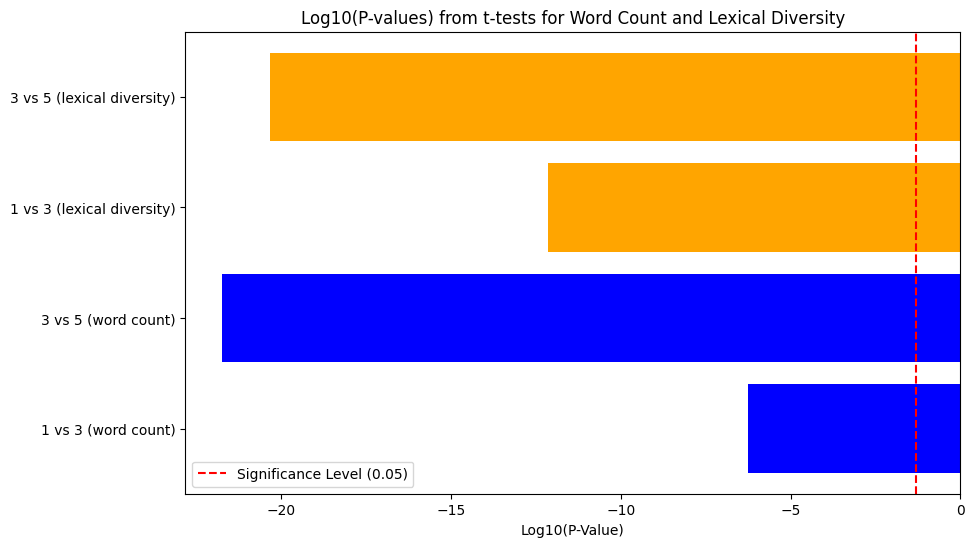

In [153]:
# Visualization of p-values (log scale for clarity)

import matplotlib.pyplot as plt
import numpy as np

p_values_word_count = [p_value_1_3_word_count, p_value_3_5_word_count]
p_values_lexical_diversity = [p_value_1_3_div, p_value_3_5_div]

labels = ['1 vs 3 (word count)', '3 vs 5 (word count)',
          '1 vs 3 (lexical diversity)', '3 vs 5 (lexical diversity)']

# Combine p-values
p_values = p_values_word_count + p_values_lexical_diversity

plt.figure(figsize=(10, 6))
plt.barh(labels, np.log10(p_values), color=['blue', 'blue', 'orange', 'orange'])

# Add a vertical line for significance level (in log scale)
plt.axvline(x=np.log10(0.05), color='r', linestyle='--', label='Significance Level (0.05)')

plt.xlabel('Log10(P-Value)')
plt.title('Log10(P-values) from t-tests for Word Count and Lexical Diversity')

plt.legend()
plt.show()


In [155]:
# Helpfulness Ratio

# Re-read full dataset from HDFS to ensure all fields are available
reviews_df = spark.read.csv("hdfs://localhost:54310/user/ubuntu/books_dataset/", 
                            header=True, inferSchema=True)

# helpfulness_ratio = helpful_votes / total_votes (safe for zero denominator)
df = reviews_df.withColumn(
    "helpfulness_ratio",
    F.when(F.col("total_votes") > 0, F.col("helpful_votes") / F.col("total_votes")).otherwise(0)
)

reviews_df.sample(withReplacement=False, fraction=0.1).limit(5).show()

+----------+--------------------+-----------+-------------+-----------+--------------------+--------------------+-----------+
|product_id|       product_title|star_rating|helpful_votes|total_votes|     review_headline|         review_body|review_date|
+----------+--------------------+-----------+-------------+-----------+--------------------+--------------------+-----------+
|1420832158|JEET KUNE DO: THE...|        5.0|          1.0|        4.0|Something  For Ev...|This book is the ...| 2005-10-13|
|0345450477|Forty Ways to Loo...|        5.0|          3.0|        3.0|40 new ways to th...|This is truly an ...| 2005-10-12|
|0446677078|What Your Doctor ...|        2.0|          9.0|       18.0|Useful for balanc...|I bought this boo...| 2005-10-11|
|1420832158|JEET KUNE DO: THE...|        5.0|          2.0|        5.0|LOVE THE FRONT COVER|I've had this boo...| 2005-10-09|
|1561840262|Monsters and Magi...|        5.0|         13.0|       15.0|One of my favorit...|This is one of my...| 2005

In [156]:
# Analyze helpfulness ratio by star rating
df.groupBy("star_rating").agg(
    F.avg("helpfulness_ratio").alias("avg_helpfulness"),
    F.count("*").alias("n_reviews")
).orderBy("star_rating").show()

# Review length for correlation analysis
df = df.withColumn("review_length", F.length("review_body"))

# Correlation between review length and helpfulness
df.select(
    F.corr("review_length", "helpfulness_ratio").alias("corr_length_helpfulness")
).show()

df_pandas = df.toPandas()

+-----------+------------------+---------+
|star_rating|   avg_helpfulness|n_reviews|
+-----------+------------------+---------+
|        1.0|0.5232437553223662|      884|
|        2.0|0.5734397707697685|      590|
|        3.0|0.5960579096637704|      846|
|        4.0| 0.652346492112155|     1862|
|        5.0|0.6899920776574328|     5818|
+-----------+------------------+---------+

+-----------------------+
|corr_length_helpfulness|
+-----------------------+
|    0.17551772153715803|
+-----------------------+



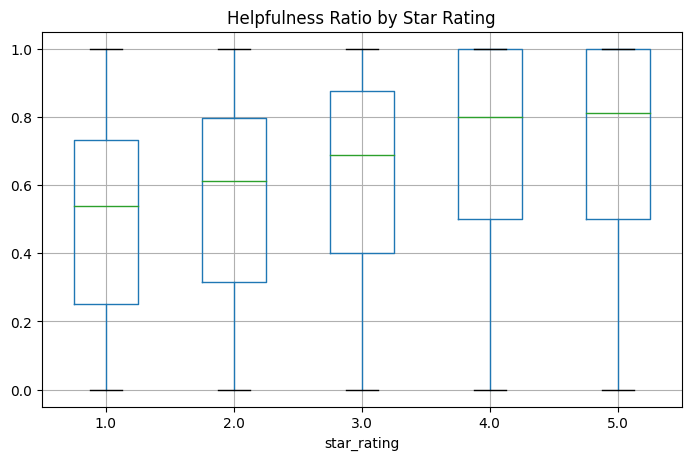

In [157]:
# Helpfulness ratio distribution

pdf = df.select("star_rating", "helpfulness_ratio").sample(fraction=0.1).toPandas()
pdf.boxplot(column="helpfulness_ratio", by="star_rating", figsize=(8,5))
plt.suptitle("")
plt.title("Helpfulness Ratio by Star Rating")
plt.show()

In [130]:
# Export results to MongoDB

import pymongo

# MongoDB instance (default port 27017)
client = pymongo.MongoClient("mongodb://localhost:27017/")

# Database and collection
db = client["books_reviews_db"]
collection = db["reviews"]

In [158]:
pdf = df.toPandas()

# Pandas → dict
records = pdf.to_dict(orient="records")

# Insert to MongoDB
collection.insert_many(records)
print(f"Inserted {len(records)} documents into MongoDB")

Inserted 10000 documents into MongoDB
